# Multi-Frame Motion Deblur Analysis
This notebook opens simulated blurred data, the recovered objects, and provides exploration

In [7]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import time
import sys
import itertools
import math
import imageio
import skimage as sk

# Libwallerlab imports
from libwallerlab.algorithms import iterative as iterative
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel 
from libwallerlab.opticsalgorithms.motiondeblur import kernel_objectives 
from libwallerlab import operators as ops
from libwallerlab.utilities import displaytools, iotools

from libwallerlab.algorithms import objectivefunctions
from libwallerlab.algorithms import regularizers
from libwallerlab.utilities.opticstools import Ft, iFt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Flow of Notebook
1. Open .npz datafile (from simulation notebook)
2. View blur paths, estimated conditioning, SSE
3. Plot and save figures

### To-Do
- make compatible with libwallerlab.utilities.iotools.Dataset format

In [8]:
savepath = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/recovered'

# Open Datafile

In [81]:
# directory and name of file of interest
datafile_dir = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred'
filename = 'raster_custom_pseudo_random_9x1' # 'raster_pseudo_random_9x1' #'raster_major_both_random_phase_18x1'

# load data and assign variables
data = np.load(datafile_dir + '/' + filename + '.npz')
#np.savez(savestring, object_true=object_true, image_size=image_size, object_edge_pad_type=object_edge_pad_type, point_list_segmented=point_list_segmented, illum_vector_list=illum_vector_list, y_list=y_list)

# Recreate Object-space Blur Paths

<IPython.core.display.Javascript object>


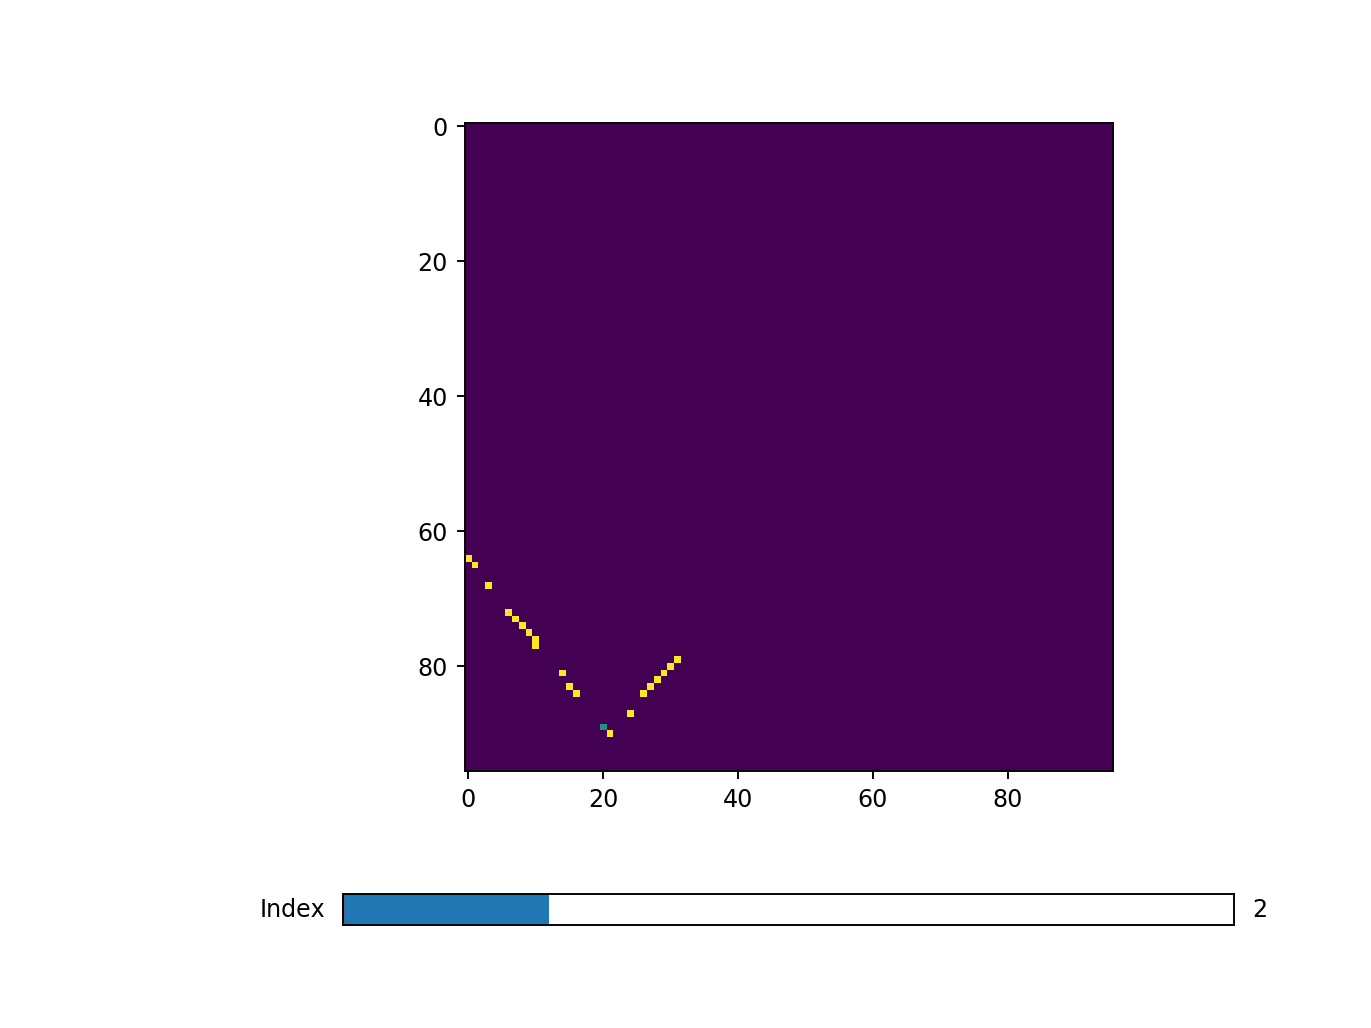

In [82]:
# Generate blur kernel maps for each frame
object_size_0 = data['object_true'].shape
illum_vector_list = data['illum_vector_list']
point_list_segmented = data['point_list_segmented']

blur_kernel_list = np.zeros((len(point_list_segmented), object_size_0[0], object_size_0[1]))
blur_path_list = np.zeros((len(point_list_segmented), object_size_0[0], object_size_0[1]))
for frame_index in range(len(illum_vector_list)):
    for position_index, position in enumerate(point_list_segmented[frame_index]):
        blur_kernel_list[frame_index, position[0], position[1]] = illum_vector_list[frame_index][position_index]
        blur_path_list[frame_index, position[0], position[1]] = illum_vector_list[frame_index][-(position_index+1)]
    blur_path_list[frame_index] = np.flipud(blur_path_list[frame_index])
    blur_path_list[frame_index] = np.fliplr(blur_path_list[frame_index])

    

# Define cropped object sizes and crop true image
object_size = blur_kernel_list[0].shape

# Show blur kernels
displaytools.show3dArray(blur_path_list, figsize=(8,6))

<IPython.core.display.Javascript object>


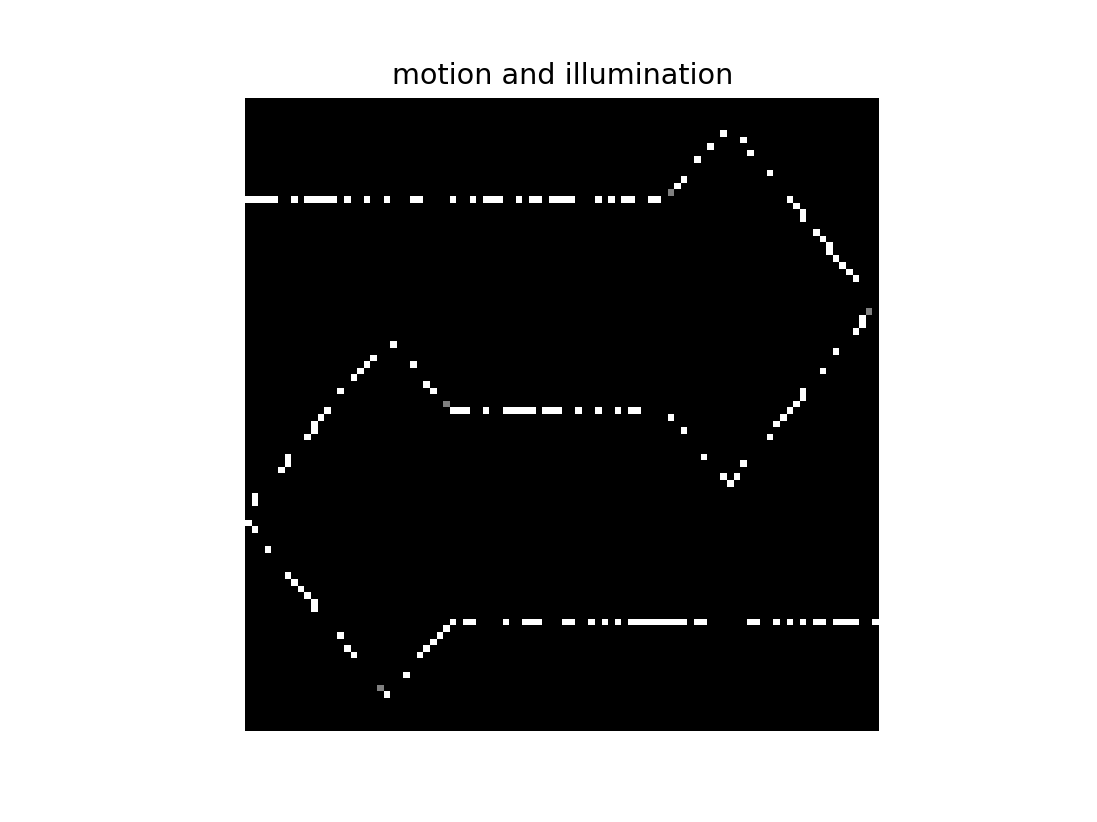

In [83]:
# transform this list into object-centric version (flip the frame positions)
plt.figure(); plt.imshow(np.sum(blur_path_list, axis=0), cmap='gray'); plt.axis('off'); plt.title('motion and illumination')
plt.savefig(savepath + '/' + filename + '/blur_illum_path.png', bbox_inches='tight')


# Multiframe Analysis

0 32 0 32
0 32 32 64
0 32 64 96
32 64 65 97
32 64 31 63
31 63 1 33
31 96 0 30
64 96 32 64
64 96 64 96


<IPython.core.display.Javascript object>


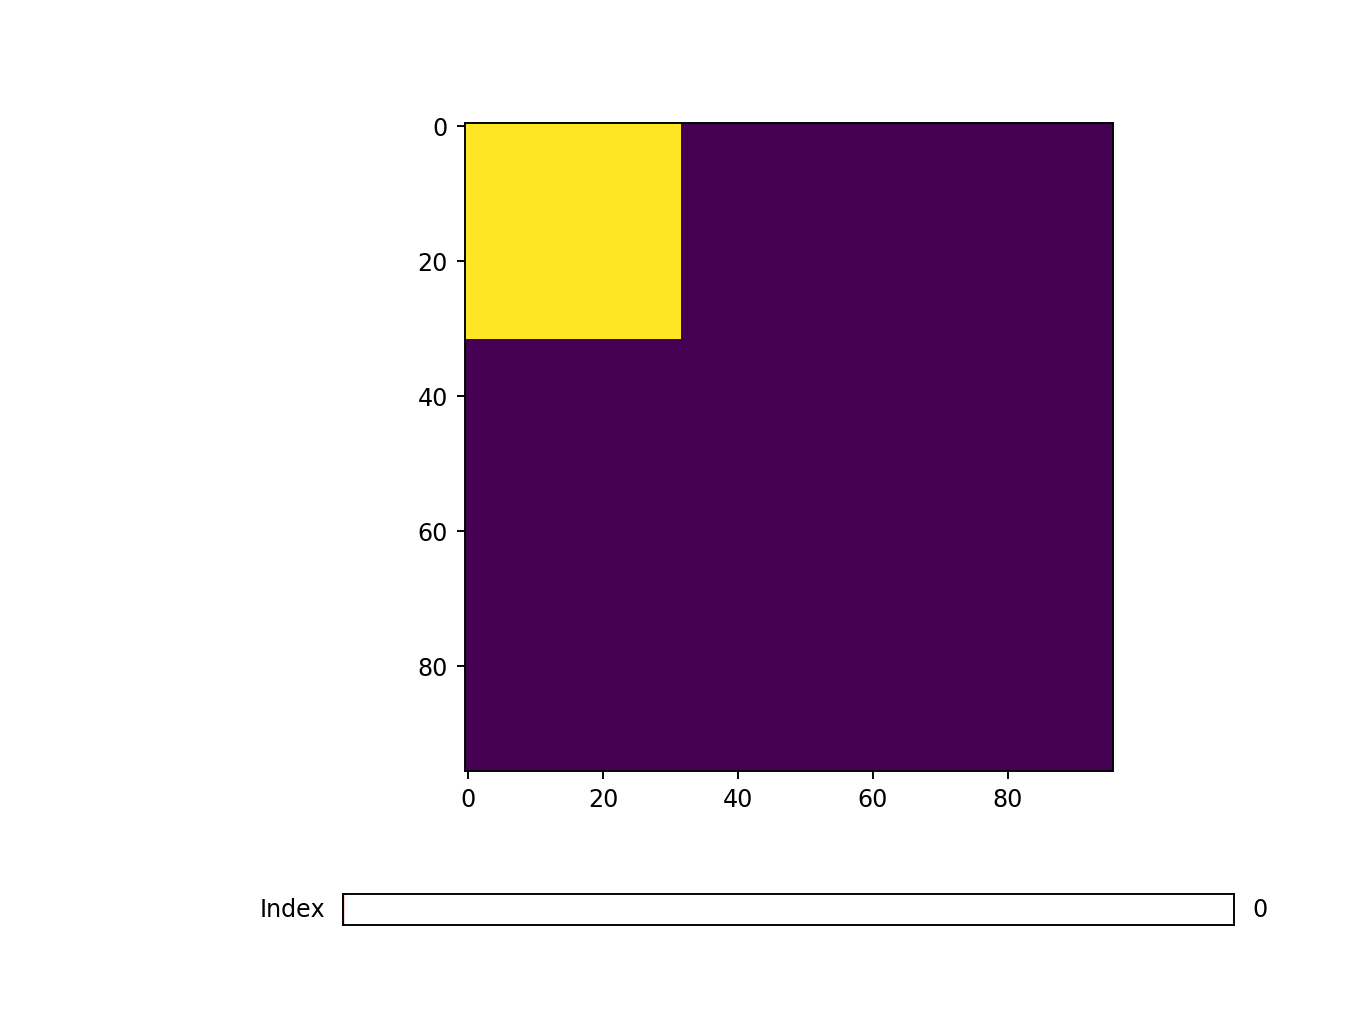

In [99]:
from libwallerlab.utilities.opticstools import iFt, Ft

# Generate windowed coverage for each frame
object_size_0 = data['object_true'].shape
illum_vector_list = data['illum_vector_list']
point_list_segmented = data['point_list_segmented']
image_size = data['image_size']


midpoint_list = []
weighted_midpoint_list = []
for frame_index, point_list in enumerate(point_list_segmented):
    nonzero_illum = np.where(illum_vector_list[frame_index].reshape(-1) != 0)
    included_point_list = point_list[np.min(nonzero_illum):(np.max(nonzero_illum)+1)]
    # weighted_midpoint_list.append(np.round(np.average(point_list, axis=0, \
    #                                                  weights=illum_vector_list[frame_index].reshape(-1)).astype(np.int)))
    midpoint_list.append(np.round(np.mean(point_list, axis=0)).astype(np.int))
    weighted_midpoint_list.append(np.round(np.mean(included_point_list, axis=0)).astype(np.int))

object_support_mask = np.zeros([len(midpoint_list), object_size[0], object_size[1]], dtype=np.int)
object_support_mask_weighted = np.zeros(object_support_mask.shape, dtype=np.int)
for frame_index in range(len(illum_vector_list)):
    position = midpoint_list[frame_index]
    weighted_position = weighted_midpoint_list[frame_index]
    
    y0,y1 = (position[0]-image_size[0] // 2, position[0]+image_size[0] // 2)
    x0,x1 = (position[1]-image_size[1] // 2, position[1]+image_size[1] // 2)
    if x0 < 0:
        x0 += 1
        y0 += 1
    object_support_mask[frame_index,y0:y1,x0:x1] = 1
    
    y0,y1 = (weighted_position[0]-image_size[0] // 2, weighted_position[0]+image_size[0] // 2)
    x0,x1 = (weighted_position[1]-image_size[1] // 2, weighted_position[1]+image_size[1] // 2)
    if x0 < 0:
        x0 = 0
        y0 = 31
    print(y0,y1,x0,x1)
    object_support_mask_weighted[frame_index,y0:y1,x0:x1] = 1

displaytools.show3dArray(object_support_mask_weighted, figsize=(8,6))

In [88]:
midpoint_list

[array([16, 16]),
 array([16, 48]),
 array([16, 80]),
 array([48, 81]),
 array([48, 48]),
 array([48, 16]),
 array([80, 15]),
 array([80, 48]),
 array([80, 80])]

<IPython.core.display.Javascript object>


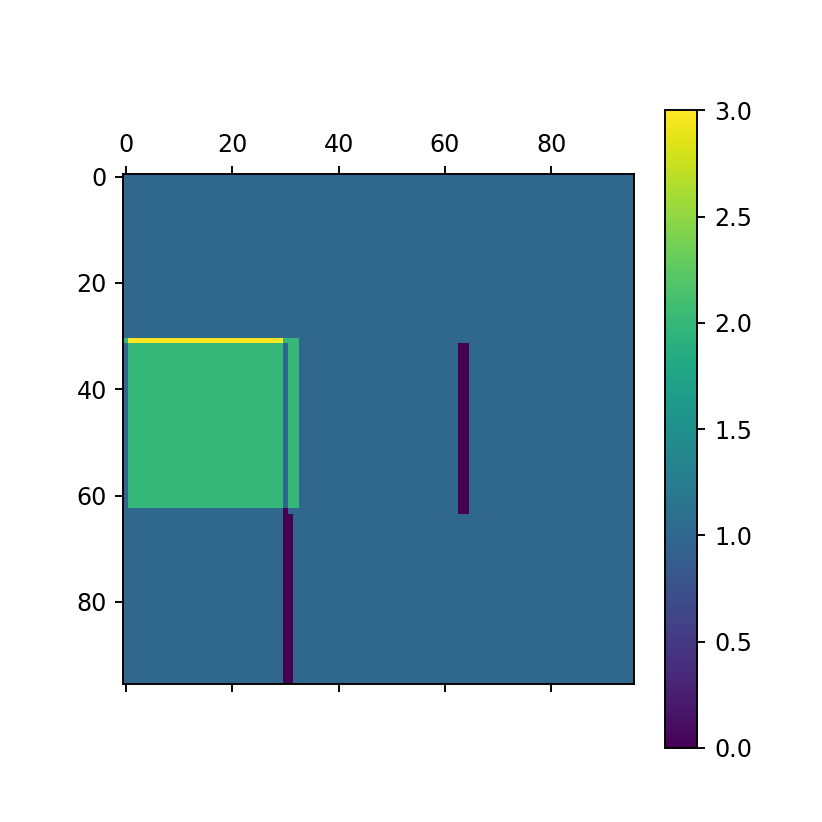

In [100]:
from itertools import combinations, chain
allsubsets = lambda n, ni_max: list(chain(*[combinations(range(n), ni) for ni in range(ni_max)]))

plt.matshow(np.sum(object_support_mask_weighted, axis=0)); plt.colorbar()
max_subset = np.amax(np.sum(object_support_mask_weighted, axis=0))
overlap_reg = allsubsets(9,max_subset)

<IPython.core.display.Javascript object>


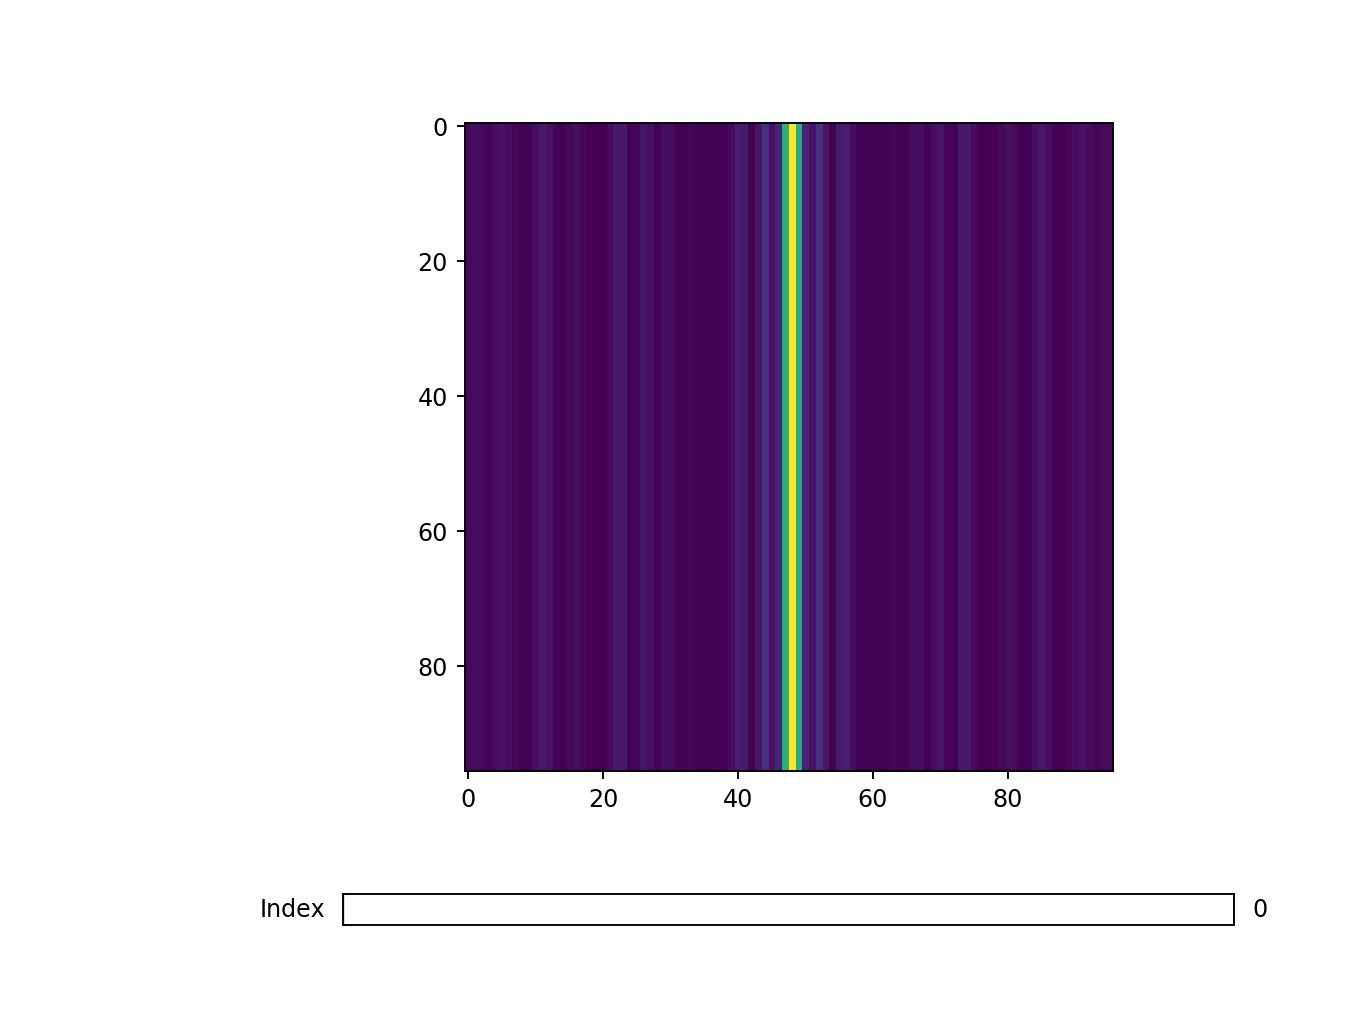

In [101]:

# list of singular values for each unwindowed blur
sv_spectrum = []
# for frame_index, point_list in enumerate(point_list_segmented):
#     blur_kernel_fourier = blurkernel.positionListToBlurKernelMap(object_size, point_list, return_fourier=True)
#     def blurMapCol(i):
#         return (blur_kernel_fourier[i]).reshape(-1).astype(np.complex64)
#     obj = kernel_objectives.kernel_objectives(blurMapCol, 1)
#     svs = obj.squaredSv(illum_vector_list[frame_index])
#     sv_spectrum.append(svs.reshape(object_size))

for blur_kernel in blur_kernel_list:
    svs = np.abs(Ft(blur_kernel.astype(np.complex64)))**2
    sv_spectrum.append(svs)
displaytools.show3dArray(sv_spectrum, figsize=(8,6))

In [102]:
# make list of singular values for each pixel
spatial_svs = np.zeros([object_size[0], object_size[1], 2])

spatial_svs_weighted = np.zeros([object_size[0], object_size[1], 2])

for i in range(object_size[0]):
    for j in range(object_size[1]):
        active_frames = np.where(object_support_mask[:,i,j] > 0)[0]
        active_frames_weighted = np.where(object_support_mask_weighted[:,i,j] > 0)[0]
        svs = np.zeros(object_size)
        for frame in active_frames:
            svs += sv_spectrum[frame]
        spatial_svs[i,j, 0] = np.amin(svs)
        spatial_svs[i,j, 1] = np.amax(svs)
        

In [103]:
spatial_min_sv = spatial_svs[:,:,0]
spatial_max_sv = spatial_svs[:,:,1]
spatial_cond = np.divide(spatial_max_sv, spatial_min_sv)

# spatial_min_sv_weighted = np.amin(spatial_svs_weighted, axis=2)
# spatial_max_sv_weighted = np.amax(spatial_svs_weighted, axis=2)
# spatial_cond_weighted = np.divide(spatial_max_sv_weighted, spatial_min_sv_weighted)

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


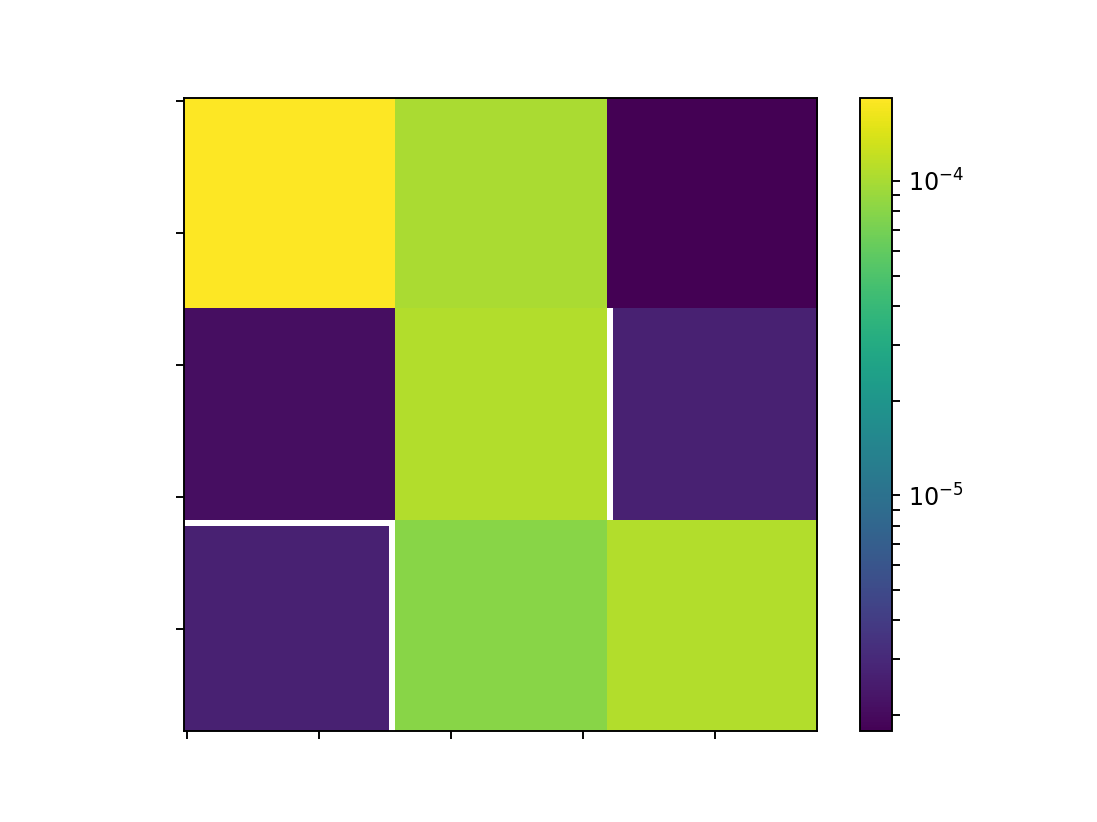

<IPython.core.display.Javascript object>


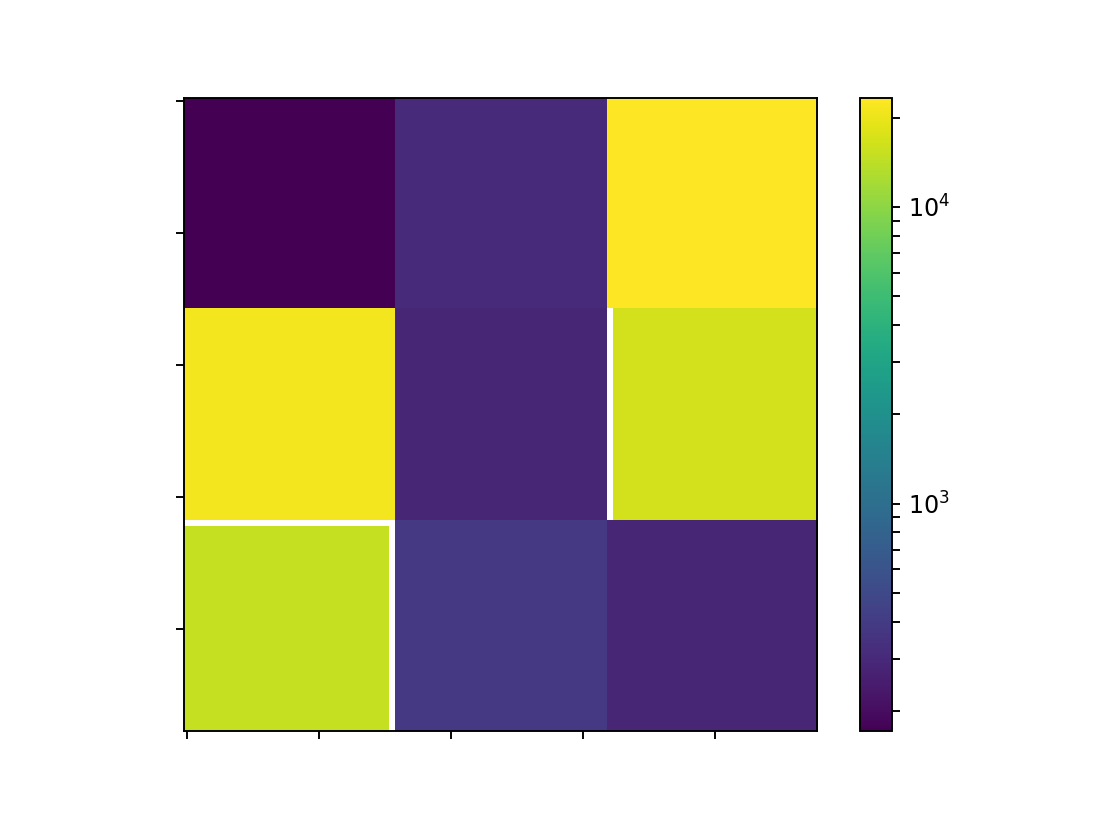

In [104]:
from matplotlib.colors import LogNorm

for toplot in ['spatial_min_sv', 'spatial_cond']:
    plt.figure(); plt.imshow(eval(toplot), cmap='viridis',norm=LogNorm()); 
    plt.colorbar(); plt.tick_params(labelbottom='off',labelleft='off')    
    
    #plt.savefig(savepath + '/' + filename + '/' + toplot + '.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


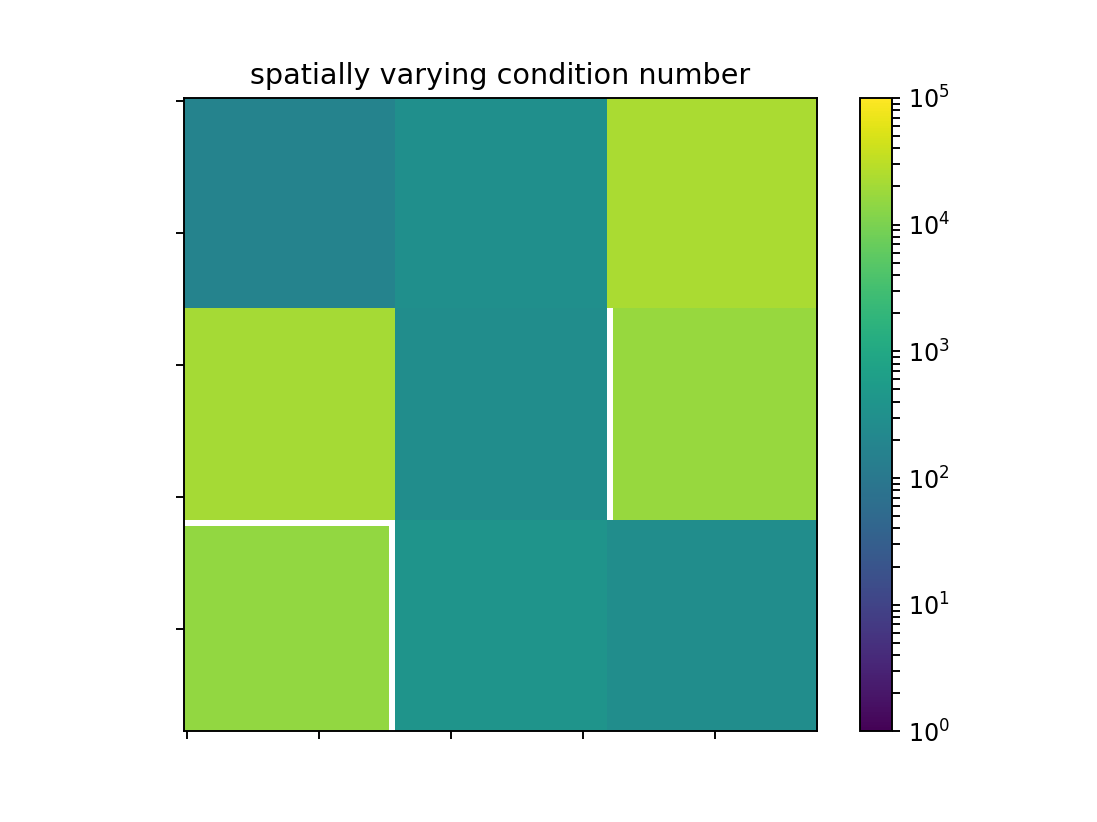

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [105]:
plt.figure(); plt.imshow(spatial_cond, cmap='viridis',norm=LogNorm()); 
plt.clim([1,100000])
plt.colorbar(); plt.tick_params(labelbottom='off',labelleft='off'); plt.title('spatially varying condition number')
plt.savefig(savepath + '/' + filename + '/' + 'spatial_cond.png', bbox_inches='tight')

## Save Recovered and Difference Images

In [54]:
# open recovered and true, make difference image, save them

<IPython.core.display.Javascript object>


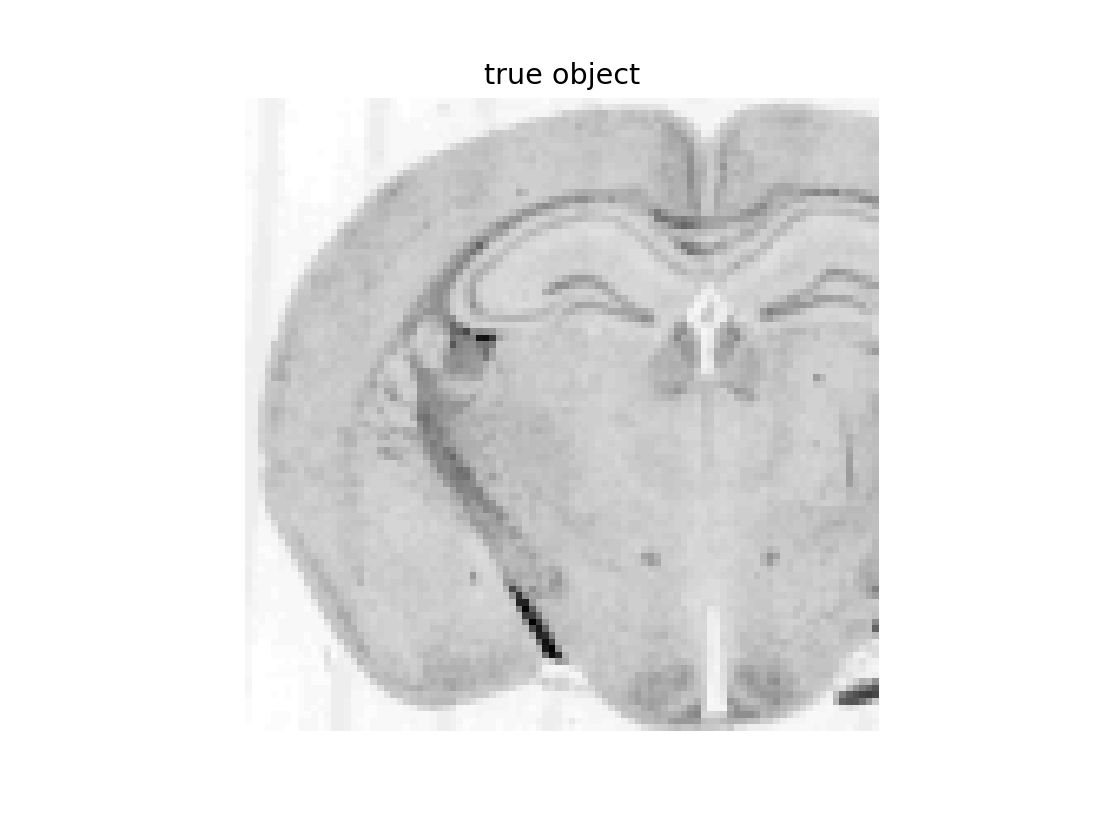

<IPython.core.display.Javascript object>


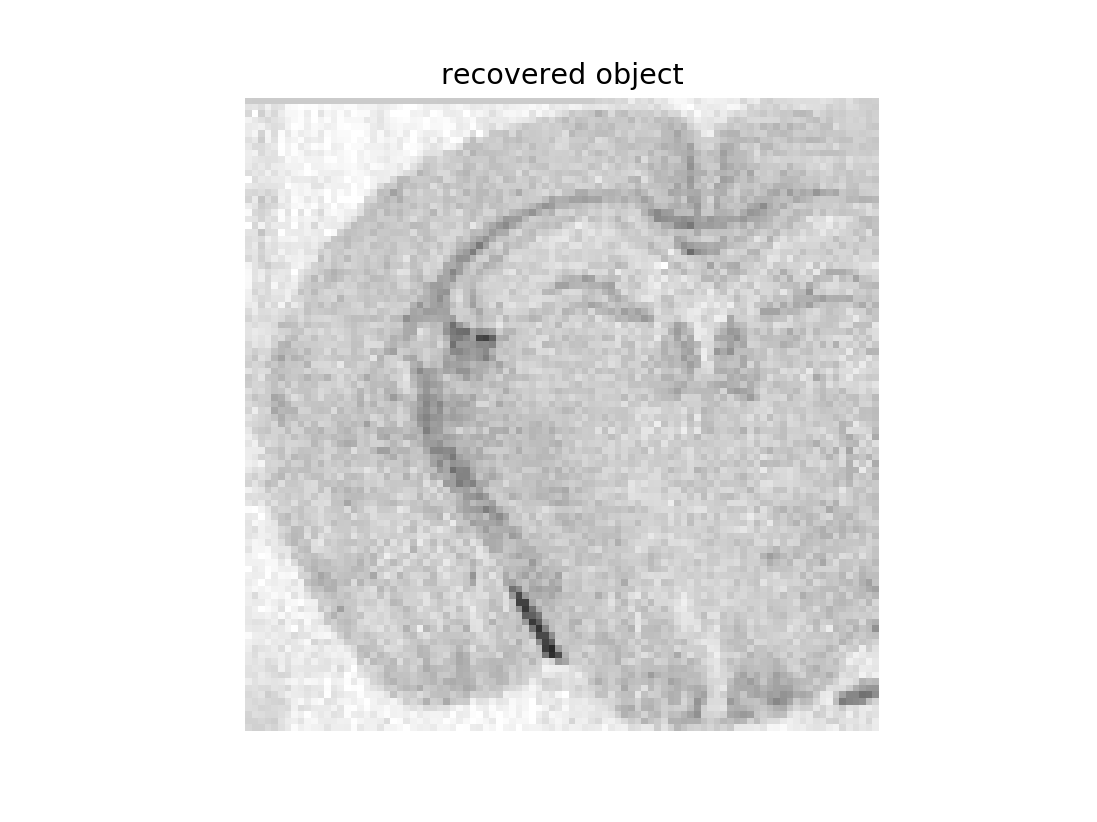

<IPython.core.display.Javascript object>


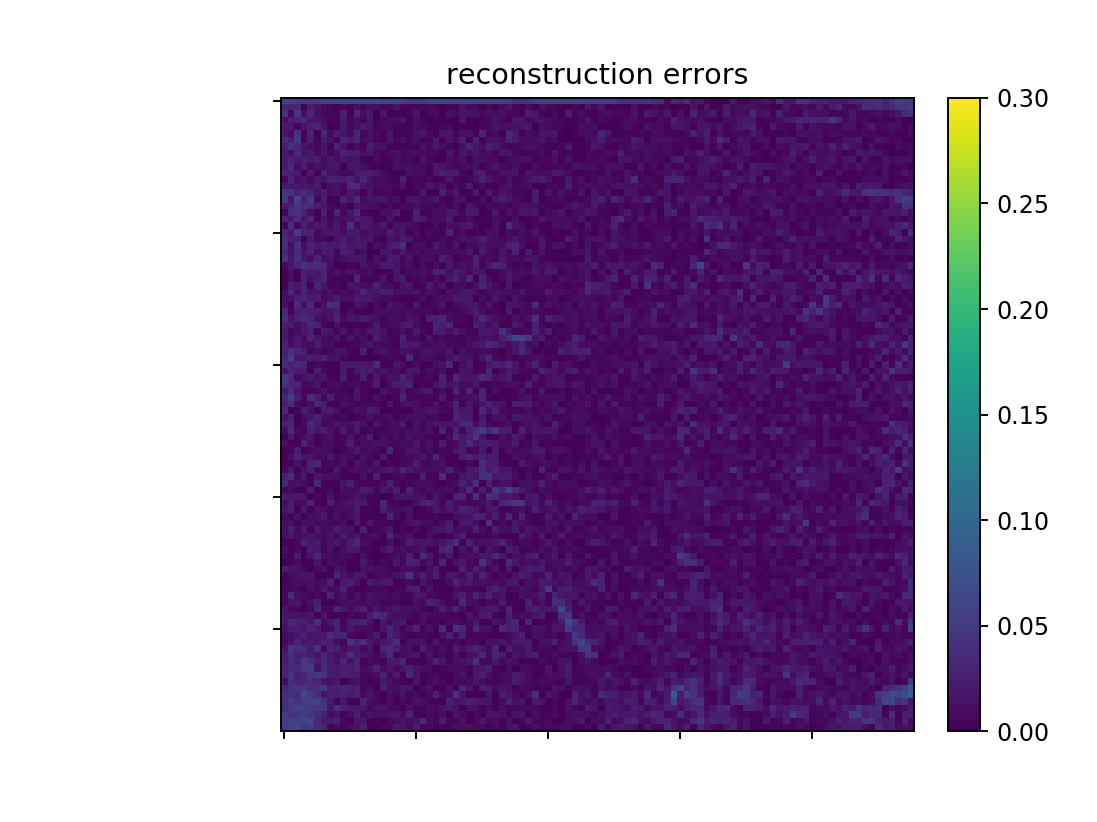

In [106]:
# normalize true object (because zero-frequency is irrelevent and recon is zero-mean)
object_true_normalized = data['object_true'] / np.mean(data['object_true'])

data2 = np.load(savepath + '/' + filename + '/recovered.npz')
object_recovered = data2['object_recovered']


plt.figure(); i_true = plt.imshow(np.abs(object_true_normalized), cmap='gray');
plt.title('true object')
plt.axis('off')

plt.figure(); i_rec = plt.imshow(np.abs(object_recovered), cmap='gray'); 
i_rec.set_clim(i_true.get_clim())
plt.title('recovered object')
plt.axis('off')
plt.savefig(savepath + '/' + filename + '/object_recovered.png', bbox_inches='tight')

plt.figure(); plt.imshow(np.abs(object_true_normalized - object_recovered), cmap='viridis'); 
plt.colorbar(fraction=0.046, pad=0.04); 
plt.tick_params(labelbottom='off',labelleft='off')    
plt.title('reconstruction errors'); plt.clim([0,0.3])
plt.savefig(savepath + '/' + filename + '/object_errors.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


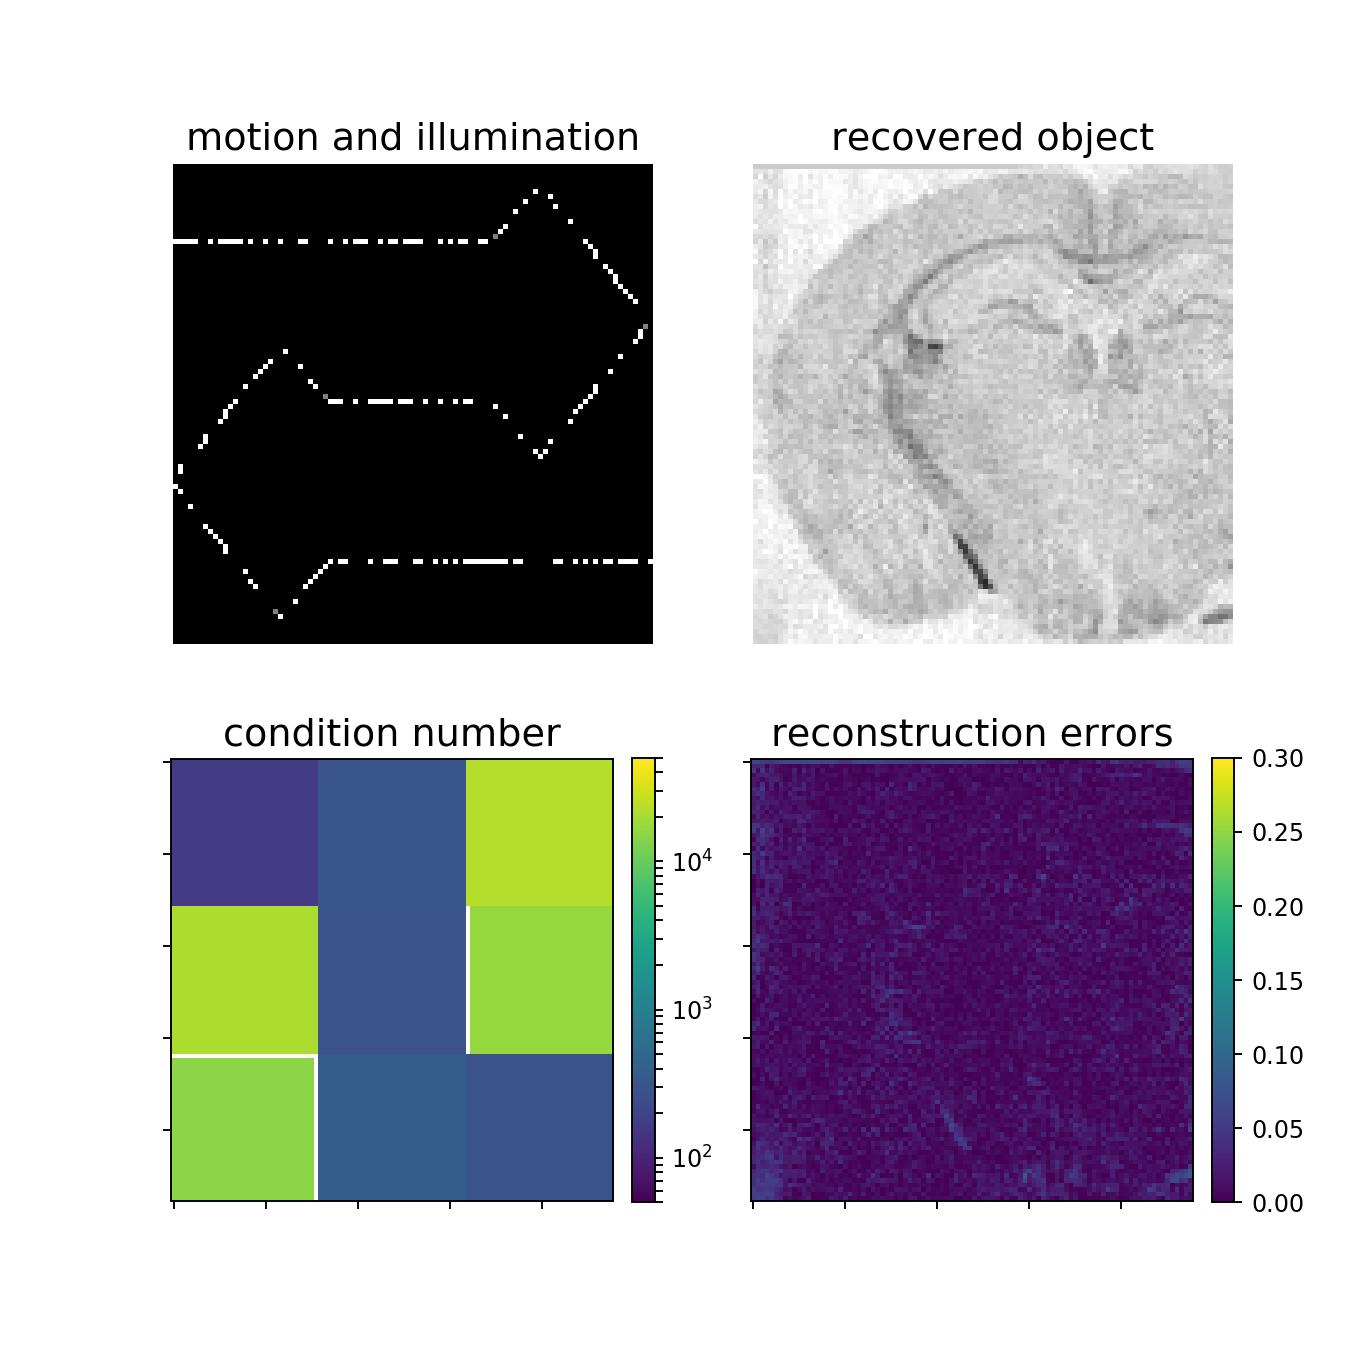

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [107]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(np.sum(blur_path_list, axis=0), cmap='gray'); plt.axis('off'); plt.title('motion and illumination', fontsize=16)

plt.subplot(2,2,2)
i_rec = plt.imshow(np.abs(object_recovered), cmap='gray'); 
i_rec.set_clim(i_true.get_clim())
plt.title('recovered object', fontsize=16)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(spatial_cond, cmap='viridis',norm=LogNorm()); 
plt.clim([50,50000])
plt.colorbar(fraction=0.046, pad=0.04); 
plt.tick_params(labelbottom='off',labelleft='off'); plt.title('condition number', fontsize=16)

plt.subplot(2,2,4)
plt.imshow(np.abs(object_true_normalized - object_recovered), cmap='viridis'); 
plt.colorbar(fraction=0.046, pad=0.04); 
plt.tick_params(labelbottom='off',labelleft='off')    
plt.title('reconstruction errors', fontsize=16); plt.clim([0,0.3])

plt.savefig(savepath + '/' + filename + '/summary_graphic.png', bbox_inches='tight')

